<a href="https://colab.research.google.com/github/KetiLaz/CNN_DNA/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image
sns.set()

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras.utils

In [20]:
#Import the data
data = pd.read_table("/content/human_data.txt")
data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [21]:
# Split the data into features (X) and labels (y)
y = data.iloc[:, 1:].values
X = data.iloc[:, 0].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

(3504,)
(3504, 1)


In [22]:
X_train_df = pd.DataFrame(X_train, columns=["sequence"])
y_train_df = pd.DataFrame(y_train, columns=["class"])
merged_df = pd.concat([X_train_df, y_train_df], axis=1)

print(merged_df)

                                               sequence  class
0     ATGCATCACCAACAGCGAATGGCTGCCTTAGGGACGGACAAAGAGC...      6
1     ATGACGAGGATTTTGACAGCTTTCAAAGTGGTGAGGACACTGAAGA...      4
2     ATGAACGGAGAAGCCGACTGCCCCACAGACCTGGAAATGGCCGCCC...      6
3     ATGGCGAACTATAGCCATGCAGCTGACAACATTTTGCAAAATCTCT...      0
4     TTGGCTGACCTGATACCTAAGGAGCAGGCCAGAATTAAGACTTTCA...      4
...                                                 ...    ...
3499  ATGGCCTCAGAAGTGGTGTGCGGGCTCATCTTCAGGCTGCTGCTGC...      5
3500  ATGCCGCCTCCTGGGAAAGTTCCCCGAAAGGAGAATCTGTGGCTAC...      6
3501  ATGGAGGCCGCCGCCCAGTTCTTCGTCGAGAGCCCGGACGTGGTCT...      4
3502  ATGGGACCAGAGGCCCTGTCATCTTTACTGCTGCTGCTCTTGGTGG...      1
3503  ATGAAGCTGCGGCTCCCTGCCAGTCCCGAGACCCACCTGGACATGC...      1

[3504 rows x 2 columns]


In [23]:
#Make data augmentations by making random insertions in order to have more data for the training

import random

def perform_random_insertion(sequence, insertion_prob, possible_nucleotides):
    augmented_sequence = sequence
    for _ in range(len(sequence)):
        if random.random() < insertion_prob:
            insert_pos = random.randint(0, len(augmented_sequence))
            insert_nucleotide = random.choice(possible_nucleotides)
            augmented_sequence = augmented_sequence[:insert_pos] + insert_nucleotide + augmented_sequence[insert_pos:]
    return augmented_sequence

# Example usage
insertion_prob = 0.1  # Insertion probability of 0.1 (10%)
possible_nucleotides = ['A', 'T', 'G', 'C']  # Set of possible nucleotides for insertion

# Assuming 'data' is a pandas DataFrame with a column 'sequence' containing DNA sequences
augmented_data = merged_df.copy()
augmented_data['augmented_sequence'] = augmented_data['sequence'].apply(
    lambda seq: perform_random_insertion(seq, insertion_prob, possible_nucleotides)
)

augmented_data = augmented_data.sample(frac=0.1, random_state=42)

# Reset the index of the DataFrame
augmented_data = augmented_data.reset_index(drop=True)

raw_sequences = merged_df
augmented_sequences = augmented_data.drop('sequence', axis=1, inplace=True)
augmented_data = augmented_data.rename(columns={'class': 'class', 'augmented_sequence': 'sequence'})
print(augmented_data)

augmented_data = augmented_data[['sequence', 'class']]
print(augmented_data)
print(data)

     class                                           sequence
0        4  GTAAAAGTGGATCGCCTTCTAACGATGATCGCCCGGCTGGGCAAGG...
1        1  ATGGATGTCTCTCTTTGCCTCAGGCCAAGTGTAGTTTCTGGCGGAT...
2        6  ATTGGCCAACATGGCTGCTGCAGCACAGATTCACAGTCCACTCTTC...
3        6  NNTCTGCCAACACAGCAACGCAGAAACTCAAGCAGGAGAACCTGAA...
4        6  ATGACGACTGAATCCTCAAACCGAATTAAGTGCATTAAAGGTCAAG...
..     ...                                                ...
345      2  AATGCGGATGGTATACTGGAAGCCGTGTTGGTGGATTTTGTTCCTG...
346      2  ATGAAACATAAGCAGAGACCCTAAATGCAGTAAACATGTTAGCTGG...
347      2  AATGTGGACAGCCAGAGGCCCCTTCAGAAGAGACAGGTGGATGCAG...
348      1  ATGGGGACCAGAGTGCCCTGTCATCTATTACTGCCTGCTGCTCTTG...
349      3  ATGTCTTTACCCTGGCTGCGGACTGTGTGTCAGGATTTCTATGTTC...

[350 rows x 2 columns]
                                              sequence  class
0    GTAAAAGTGGATCGCCTTCTAACGATGATCGCCCGGCTGGGCAAGG...      4
1    ATGGATGTCTCTCTTTGCCTCAGGCCAAGTGTAGTTTCTGGCGGAT...      1
2    ATTGGCCAACATGGCTGCTGCAGCACAGATTCACAGTCCAC

In [24]:
y_train = data.iloc[:, 1:].values
X_train = data.iloc[:, 0].values

# Determine the maximum sequence length
max_length_test = max(len(seq) for seq in X_test)

max_length_train = max(len(seq) for seq in X_train)

max_length = max(max_length_test, max_length_train)

print(max_length)

18921


In [25]:
# Create a dictionary to map nucleotide bases to numerical values
base_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N':4}

# Encode the DNA sequences for the testing and training sets
X_test_encoded = []
for seq1 in X_test:
    encoded_seq = [base_to_int[base] for base in seq1]
    X_test_encoded.append(encoded_seq)

X_train_encoded = []
for seq2 in X_train:
    encoded_seq = [base_to_int[base] for base in seq2]
    X_train_encoded.append(encoded_seq)


# Pad or truncate sequences
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length)
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length)

# Convert the encoded sequences to one-hot encoding
X_test = to_categorical(X_test_padded)
X_train = to_categorical(X_train_padded)

In [26]:
# Reshape the input features
X_train = X_train.reshape(-1, max_length, 5)
X_test = X_test.reshape(-1, max_length, 5)

In [27]:
#Define the model
model = keras.Sequential([
    keras.layers.Conv1D(32, 5, activation='relu', input_shape=(max_length, 5)),
    keras.layers.MaxPooling1D(3),
    keras.layers.Conv1D(64, 10, activation='relu'),
    keras.layers.MaxPooling1D(3),
    keras.layers.Dropout(0.1),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(7, activation='softmax')
])

In [28]:
#Compile and validate(validation_data()) the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
137/137 [==============================] - 204s 1s/step - loss: 2.0230 - accuracy: 0.2676 - val_loss: 1.7757 - val_accuracy: 0.3185
Epoch 2/20
137/137 [==============================] - 186s 1s/step - loss: 1.7536 - accuracy: 0.3160 - val_loss: 1.6952 - val_accuracy: 0.3242
Epoch 3/20
137/137 [==============================] - 194s 1s/step - loss: 1.6774 - accuracy: 0.3249 - val_loss: 1.6108 - val_accuracy: 0.3516
Epoch 4/20
137/137 [==============================] - 193s 1s/step - loss: 1.6043 - accuracy: 0.3498 - val_loss: 1.5243 - val_accuracy: 0.3984
Epoch 5/20
137/137 [==============================] - 192s 1s/step - loss: 1.4865 - accuracy: 0.4025 - val_loss: 1.3791 - val_accuracy: 0.4600
Epoch 6/20
137/137 [==============================] - 190s 1s/step - loss: 1.3422 - accuracy: 0.4852 - val_loss: 1.2074 - val_accuracy: 0.5228
Epoch 7/20
137/137 [==============================] - 187s 1s/step - loss: 1.2133 - accuracy: 0.5406 - val_loss: 1.0856 - val_accuracy: 0.6313

Training Accuracy: 0.9769
Testing Accuracy:  0.9726


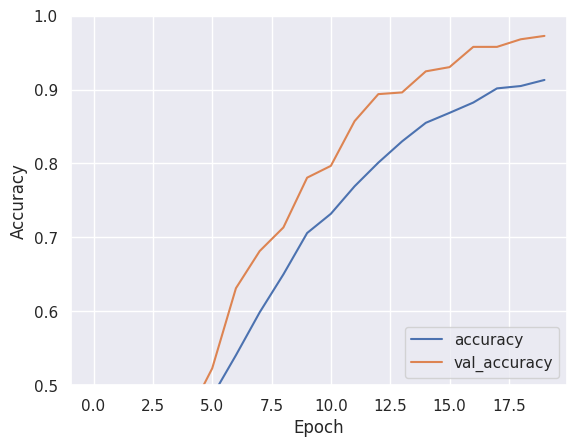

In [29]:
print(history)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Make a prediction with the dog DNA sequence
Predict_data = pd.read_table('/content/dog_data.txt')

Predict_data_class = Predict_data.iloc[:, 1:].values
Predict_data_Seq = Predict_data.iloc[:, 0].values


Predict_data_Seq_encoded = []
for seq4 in Predict_data_Seq:
    Predict_data_Seq_encoded_seq = [base_to_int[base] for base in seq4]
    Predict_data_Seq_encoded.append(Predict_data_Seq_encoded_seq)


# Pad or truncate sequences
Predict_data_Seq_padded = pad_sequences(Predict_data_Seq_encoded, maxlen=max_length)


# Convert the encoded sequences to one-hot encoding
Predict_data_Seq = to_categorical(Predict_data_Seq_padded)

In [ ]:
# Make predictions
predictions = model.predict(Predict_data_Seq)
predicted_classes = predictions.argmax(axis=1)


In [ ]:
# Convert predicted_classes and Predict_data_class to numpy arrays
predicted_classes_arr = np.array(predicted_classes)
Predict_data_class_arr = np.array(Predict_data_class).flatten()

# Calculate the percentage of common values
percentage_common = np.mean(predicted_classes_arr == Predict_data_class_arr) * 100

# Print the percentage
print("Percentage of common values for Dog dataset: {:.2f}%".format(percentage_common))

In [ ]:
Predict_data2 = pd.read_table('/content/chimp_data.txt')

Predict_data_class2 = Predict_data2.iloc[:, 1:].values
Predict_data_Seq2 = Predict_data2.iloc[:, 0].values


Predict_data_Seq_encoded1 = []
for seq5 in Predict_data_Seq2:
    Predict_data_Seq_encoded_seq = [base_to_int[base] for base in seq5]
    Predict_data_Seq_encoded1.append(Predict_data_Seq_encoded_seq)


# Pad or truncate sequences
Predict_data_Seq2_padded = pad_sequences(Predict_data_Seq_encoded1, maxlen=max_length)


# Convert the encoded sequences to one-hot encoding
Predict_data_Seq2 = to_categorical(Predict_data_Seq2_padded)

In [ ]:
# Make predictions
predictions2 = model.predict(Predict_data_Seq2)
predicted_classes2 = predictions2.argmax(axis=1)

In [ ]:
# Convert predicted_classes and Predict_data_class to numpy arrays
predicted_classes_arr = np.array(predicted_classes2)
Predict_data_class_arr = np.array(Predict_data_class2).flatten()

# Calculate the percentage of common values
percentage_common = np.mean(predicted_classes_arr == Predict_data_class_arr) * 100

# Print the percentage
print("Percentage of common values for Chimp dataset: {:.2f}%".format(percentage_common))